# A simple autoencoder in PyTorch

**[Faisal Z. Qureshi](http://vclab.science.uoit.ca)**  

Check out excellent PyTorch tutorials by "SherlockLiao" at [https://github.com/L1aoXingyu/pytorch-beginner](https://github.com/L1aoXingyu/pytorch-beginner)

In [1]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torch.autograd import Variable

import torchvision
from torchvision import transforms
from torchvision.datasets import MNIST
from torchvision.utils import save_image

import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

## CUDA Support

In [2]:
for i in range(torch.cuda.device_count()):
    print("Found device: {} - {}".format(i,torch.cuda.get_device_name(i)))

if torch.cuda.device_count() == 0:
    print("No GPU device found")
else:
    print("Current cuda device is", torch.cuda.get_device_name(torch.cuda.current_device()))

Found device: 0 - GeForce GTX TITAN X
Found device: 1 - GeForce GTX 980
Current cuda device is GeForce GTX TITAN X


Some helper code that would allow us to use gpu and cpu seemlessly, I think.

In [3]:
class cudafy:
    
    def __init__(self, device=None):
        if torch.cuda.is_available() and device:
            self.device = device
        else:
            self.device = 0
    
    def name(self):
        if torch.cuda.is_available():
            return torch.cuda.get_device_name(self.device)
        return 'Cuda is not available.'
    
    def put(self, x):
        """Put x on the default cuda device."""
        if torch.cuda.is_available():
            return x.to(device=self.device)
        return x

    def __call__(self, x):
        return self.put(x)
    
    def get(self,x):
        """Get from cpu."""
        if x.is_cuda:
            return x.to(device='cpu')
        return x
    
def cpu(x):
    if x.is_cuda:
        return x.to(device='cpu')
    return x

In [4]:
gpu = cudafy()
x = torch.ones((3,2))
y = gpu(x)
z = cpu(y)
w = cpu(x)

print(gpu.name())
print('x is not on cuda', x.is_cuda)
print('y is on cuda (if possible)', y.is_cuda)
print('z is taken from y, z is not on cuda', z.is_cuda)
print('w is taken from x, w is not on cuda', w.is_cuda)

GeForce GTX TITAN X
x is not on cuda False
y is on cuda (if possible) True
z is taken from y, z is not on cuda False
w is taken from x, w is not on cuda False


## Set up MNIST dataset

For single channel images, don't forget the trailing commas as seen below.

`transforms.Normalize((0.5,),(0.5,))`

We normalize the MNIST images in this manner to ensure that pixel values lie between -0.5 and 0.5.  This allows us to use a sigmoid when predicting pixel values.

In [4]:
batch_size = 128

my_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

dataset = MNIST('../datasets', transform=my_transforms, download=True)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

Lets check out the data

Size of dataset:  60000


Text(0.5, 1.0, 'idx = 41149, Label = 6')

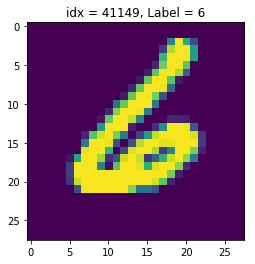

In [5]:
print('Size of dataset: ', len(dataset))
idx = np.random.choice(len(dataset))
x, y = dataset[idx]

plt.figure()
plt.imshow(x.squeeze())
plt.title('idx = {}, Label = {}'.format(idx,y))

Method `to_img` is the opposite of what `Normalize` above does to an MNIST image.

In [6]:
def to_img(x):
    x = 0.5 * (x + 1)
    x = x.clamp(0, 1)
    x = x.view(x.size(0), 1, 28, 28)
    return x

## Lets make an autoencoder

In [7]:
class autoencoder(nn.Module):
    
    def __init__(self):
        super(autoencoder, self).__init__()
        
        self.encoder = nn.Sequential(
            nn.Linear(28 * 28, 128),
            nn.ReLU(True),
            nn.Linear(128, 64),
            nn.ReLU(True), 
            nn.Linear(64, 12), 
            nn.ReLU(True), 
            nn.Linear(12, 3))
        
        self.decoder = nn.Sequential(
            nn.Linear(3, 12),
            nn.ReLU(True),
            nn.Linear(12, 64),
            nn.ReLU(True),
            nn.Linear(64, 128),
            nn.ReLU(True), 
            nn.Linear(128, 28 * 28), # arbitrary values
            nn.Tanh())               # squished between -1 and 1
        
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

## Set up training

In [8]:
gpu = cudafy()

learning_rate = 1e-2
weight_decay = 1e-5

model = gpu(autoencoder())

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), 
                             lr=learning_rate, 
                             weight_decay=weight_decay)

### Now we train

In [9]:
num_epochs = 100

for epoch in range(num_epochs):
    
    for data in dataloader:        
        img, _ = data # img is a [batch_size, num_channels, 28, 28] tensor
                      # here num_channels is 1
            
        img = img.view(img.size(0), -1) # We resize it to [batchsize, 1x28x28] tensor
        img = gpu(Variable(img))

        output = model(img) # Forward
        loss = criterion(output, img)

        optimizer.zero_grad() # Backward & update weights
        loss.backward()
        optimizer.step()
        
    print('epoch [{}/{}], loss:{:.4f}'
          .format(epoch + 1, num_epochs, loss.data.item()))
    if epoch % 10 == 0:
        pic = to_img(output.cpu().data)
        save_image(pic, 'image_{}.png'.format(epoch))

epoch [1/100], loss:0.1609
epoch [2/100], loss:0.1489
epoch [3/100], loss:0.1413
epoch [4/100], loss:0.1394
epoch [5/100], loss:0.1502
epoch [6/100], loss:0.1591
epoch [7/100], loss:0.1477
epoch [8/100], loss:0.1468
epoch [9/100], loss:0.1468
epoch [10/100], loss:0.1427
epoch [11/100], loss:0.1354
epoch [12/100], loss:0.1366
epoch [13/100], loss:0.1446
epoch [14/100], loss:0.1442
epoch [15/100], loss:0.1328
epoch [16/100], loss:0.1427
epoch [17/100], loss:0.1389
epoch [18/100], loss:0.1430
epoch [19/100], loss:0.1432
epoch [20/100], loss:0.1418
epoch [21/100], loss:0.1250
epoch [22/100], loss:0.1256
epoch [23/100], loss:0.1493
epoch [24/100], loss:0.1316
epoch [25/100], loss:0.1476
epoch [26/100], loss:0.1462
epoch [27/100], loss:0.1292
epoch [28/100], loss:0.1342
epoch [29/100], loss:0.1408
epoch [30/100], loss:0.1453
epoch [31/100], loss:0.1324
epoch [32/100], loss:0.1370
epoch [33/100], loss:0.1381
epoch [34/100], loss:0.1420
epoch [35/100], loss:0.1443
epoch [36/100], loss:0.1282
e

## Saving the trained model

Now that training is done, it is a good idea to save the trained model.

We are interested in state_dict dictionary that contains parameters associated with each layer in the model.  Optimizer too has a state_dict.

In [11]:
print("Model's state_dict:")
for param_tensor in model.state_dict():
    print(param_tensor, " -- " , model.state_dict()[param_tensor].size())

Model's state_dict:
encoder.0.weight  --  torch.Size([128, 784])
encoder.0.bias  --  torch.Size([128])
encoder.2.weight  --  torch.Size([64, 128])
encoder.2.bias  --  torch.Size([64])
encoder.4.weight  --  torch.Size([12, 64])
encoder.4.bias  --  torch.Size([12])
encoder.6.weight  --  torch.Size([3, 12])
encoder.6.bias  --  torch.Size([3])
decoder.0.weight  --  torch.Size([12, 3])
decoder.0.bias  --  torch.Size([12])
decoder.2.weight  --  torch.Size([64, 12])
decoder.2.bias  --  torch.Size([64])
decoder.4.weight  --  torch.Size([128, 64])
decoder.4.bias  --  torch.Size([128])
decoder.6.weight  --  torch.Size([784, 128])
decoder.6.bias  --  torch.Size([784])


In [12]:
print("Optimizer's state_dict:")
for var_name in optimizer.state_dict():
    print(var_name)
    #print(var_name, "\t", optimizer.state_dict()[var_name])

Optimizer's state_dict:
state
param_groups


PyTorch preferred approach to save the model is to use model's state_dict.

We have commented it out, so we don't overwrite the file mistakenly.

In [13]:
torch.save(model.state_dict(), 'simple-ae-weights-100.pt')

## Inference

Now lets pass an image through the learned model and see what we get

torch.Size([1, 28, 28]) tensor(0)


Text(0.5, 1.0, 'idx = 0, Label = 0')

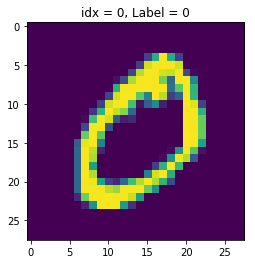

In [14]:
image, label = dataset[1]
print(image.shape, label)

idx = 0
plt.figure()
plt.imshow(image[idx])
plt.title('idx = {}, Label = {}'.format(idx, label))

We now pass this image through the network and see what we get.  We will have to "normalize" and "de-normalize" the data as needed.  We also use `unsqueeze_()` to create a batch of size 1.  Recall that our model expects data to be in the form: batch x ...

In [10]:
ni = image
ni.unsqueeze_(0)
ni = ni.view(1, -1)
print('batch x (28 x 28) = ', ni.shape)

#if torch.cuda.is_available():
#    ni = Variable(ni).cuda() # Lets put this on Cuda
#else:
#    ni = Variable(ni)


oi = model(gpu(ni))
#print(oi.shape)
oi_ = to_img(oi)
#print(oi_.shape)

plt.imshow(cpu(oi_[0,0,:,:].detach()))

NameError: name 'image' is not defined

## Loading the saved model

We can easily load the model as follows

In [17]:
gpu = cudafy()
model2 = gpu(autoencoder())

The following should produce garbage, since we haven't trained the model yet

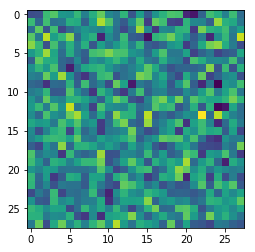

In [18]:
oi = model2(gpu(ni))
oi_ = to_img(oi)
plt.imshow(cpu(oi_[0,0,:,:].detach()))

Now lets load the model and see what happens

In [ ]:
model2.load_state_dict(torch.load('simple-ae-weights.pt', map_location='cpu'))
oi = model2(gpu(ni))
oi_ = to_img(oi)
plt.imshow(cputoi_[0,0,:,:].detach())

Notice that when you load the model all is well in the world of autoencoders

## Using part of the trained network

Now lets assume we are interested in the **encoder** stage only.  I.e., we want to pass an MNIST image and wants to get its 3-dimensional encoding.  We can do it as follows.

In [ ]:
class my_encoder(nn.Module):
    def __init__(self):
        super(my_encoder, self).__init__()
        
        self.features = nn.Sequential(*list(model2.encoder.children())[:])
    
    def forward(self, x):
        x = self.features(x)
        return x

In [ ]:
encoder = gpu(my_encoder())
encoding = encoder(gpu(ni))
print(encoding.detach())

What if we only care about the **decoder** stage.

In [ ]:
class my_decoder(nn.Module):
    def __init__(self):
        super(my_decoder, self).__init__()
        
        self.reconstruction = nn.Sequential(*list(model2.decoder.children())[:])
    
    def forward(self, x):
        x = self.reconstruction(x)
        return x

In [ ]:
v = torch.empty((1,3))
v[0,0] = 0.01
v[0,1] = 0.0001
v[0,2] = 1
print(v)

d = my_decoder()
ooi = d(gpu(v))
print(ooi.shape)
ooi_ = to_img(ooi)
plt.imshow(ooi_[0,0,:,:].detach())